In [3]:

#Set hyperparameters

epochs = 1000
batch_size = 32 #optimal: 32
lr = 5e-4
dataset = 'ncars'  # 'ncars' or 'ncaltech'
convType="fuse" #fuse or ori_aegnn
ncars_path = r'/Users/hannes/Documents/University/Datasets/raw_ncars/Prophesee_Dataset_n_cars'
ncaltech_path =r'/Users/hannes/Documents/University/Datasets/raw_ncaltec'


# EvGNN Training Pipeline

In [4]:


import sys, os
# Set MPS fallback BEFORE importing torch
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../src', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# comment out if youre on windows and remove 'src.' prefixes from imports #

from src.Datasets.batching import BatchManager

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW



# Configuration: Device Selection

In [5]:
# Device options: 'auto', 'mps', 'cuda', 'cpu'
USE_DEVICE = 'cpu'  # 'auto' = try MPS/CUDA first, fallback to CPU

CPU_THREADS = 8
# Apply settings
torch.set_num_threads(CPU_THREADS)

if USE_DEVICE == 'cpu':
    device = torch.device("cpu")
    print(f"Using device: cpu with {CPU_THREADS} threads (forced)")
elif USE_DEVICE == 'mps':
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"Using device: mps (Apple Silicon GPU with CPU fallback for unsupported ops)")
        print(f"CPU operations will use {CPU_THREADS} threads")
    else:
        device = torch.device("cpu")
        print(f"MPS not available, falling back to cpu with {CPU_THREADS} threads")
elif USE_DEVICE == 'cuda':
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using device: cuda")
    else:
        device = torch.device("cpu")
        print(f"CUDA not available, falling back to cpu with {CPU_THREADS} threads")
else:  # 'auto'
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"Using device: mps (Apple Silicon GPU with CPU fallback)")
        print(f"CPU operations will use {CPU_THREADS} threads")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using device: cuda")
    else:
        device = torch.device("cpu")
        print(f"Using device: cpu with {CPU_THREADS} threads")

Using device: cpu with 8 threads (forced)


# Dataset Selection

In [6]:
from src.Datasets.ncaltech101 import NCaltech
from src.Datasets.ncars import NCars
if dataset == 'ncars':

    num_classes = len(NCars.get_info().classes)
    image_size = NCars.get_info().image_size
elif dataset == 'ncaltech':

    num_classes = len(NCaltech.get_info().classes)
    image_size = NCaltech.get_info().image_size

print(f"Dataset: {dataset}")
print(f"Number of classes: {num_classes}")

Dataset: ncars
Number of classes: 2


# Model Setup

In [7]:
from src.Models.CleanEvGNN.recognition import RecognitionModel as EvGNN
from torch_geometric.data import Data as PyGData

img_shape_for_model = (image_size[1], image_size[0])  # Swap to (width, height)

evgnn = EvGNN(
    network="graph_res",
    dataset=dataset,
    num_classes=num_classes,
    img_shape=img_shape_for_model,
    dim=3,
    conv_type=convType,
    distill=False
).to(device)

def transform_graph(graph: PyGData) -> PyGData:
    return evgnn.data_transform(
        graph, n_samples=10000, sampling=True,
        beta=0.5e-5, radius=3.0, max_neighbors=16
    ).to(device)

# Dataset Loading

In [8]:
if dataset == 'ncaltech':
    dataset_obj = NCaltech(
        root=ncaltech_path,
        transform=transform_graph
    )
elif dataset == 'ncars':
    dataset_obj = NCars(
        root=ncars_path,
        transform=transform_graph
    )

dataset_obj.process(modes=["training"])
num_training_samples = dataset_obj.get_mode_length("training")
print(f"Training samples: {num_training_samples}")

training_set = BatchManager(
    dataset=dataset_obj,
    batch_size=batch_size,
    mode="training"
)

training (cars):   0%|          | 0/7940 [00:00<?, ?it/s]

Error processing line 1 of /opt/anaconda3/envs/GNNBenchmark/lib/python3.11/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 195, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored


training (background):   0%|          | 0/7482 [00:00<?, ?it/s]

Training samples: 13879


# Training Loop

In [9]:



optimizer = AdamW(evgnn.parameters(), lr=lr, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=250, cooldown = 25)
loss_fn = CrossEntropyLoss()

print("Starting training...")

evgnn.train()
losses = []

for i in range(epochs):
    optimizer.zero_grad()
    examples = next(training_set)
    reference = examples.y.to(device)

    out = evgnn(examples)
    loss = loss_fn(out, reference)

    if torch.isnan(loss) or torch.isinf(loss):
        print(f"Loss is NaN/Inf at iteration {i}!")
        break

    loss.backward()
    torch.nn.utils.clip_grad_norm_(evgnn.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss.item())

    losses.append(loss.item())

    if i % 10 == 0:
        with torch.no_grad():
            predictions = out.argmax(dim=-1)
            accuracy = (predictions == reference).float().mean().item()
        print(f"Iteration {i:4d} | Loss: {loss.item():.4f} | Acc: {accuracy:.3f}")

print(f"\n✅ Training complete!")


Starting training...
Iteration    0 | Loss: 0.7464 | Acc: 0.438
Iteration   10 | Loss: 0.6360 | Acc: 0.625
Iteration   20 | Loss: 0.5418 | Acc: 0.719
Iteration   30 | Loss: 0.4593 | Acc: 0.812
Iteration   40 | Loss: 0.5146 | Acc: 0.719
Iteration   50 | Loss: 0.4803 | Acc: 0.812
Iteration   60 | Loss: 0.3814 | Acc: 0.812
Iteration   70 | Loss: 0.3076 | Acc: 0.875
Iteration   80 | Loss: 0.6321 | Acc: 0.656
Iteration   90 | Loss: 0.2799 | Acc: 0.906
Iteration  100 | Loss: 0.3434 | Acc: 0.844
Iteration  110 | Loss: 0.2596 | Acc: 0.938
Iteration  120 | Loss: 0.1656 | Acc: 0.969
Iteration  130 | Loss: 0.2631 | Acc: 0.938
Iteration  140 | Loss: 0.2944 | Acc: 0.875
Iteration  150 | Loss: 0.4044 | Acc: 0.812
Iteration  160 | Loss: 0.2859 | Acc: 0.844
Iteration  170 | Loss: 0.4556 | Acc: 0.750
Iteration  180 | Loss: 0.2572 | Acc: 0.938
Iteration  190 | Loss: 0.3895 | Acc: 0.719
Iteration  200 | Loss: 0.2650 | Acc: 0.875
Iteration  210 | Loss: 0.2340 | Acc: 0.906
Iteration  220 | Loss: 0.1680 | A

In [10]:
# Save model in results directory
os.makedirs('../results/TrainedModels', exist_ok=True)
model_path = f'../results/TrainedModels/evgnn_{dataset}_{convType}.pth'
torch.save(evgnn.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../results/TrainedModels/evgnn_ncars_fuse.pth


# Loss Visualization

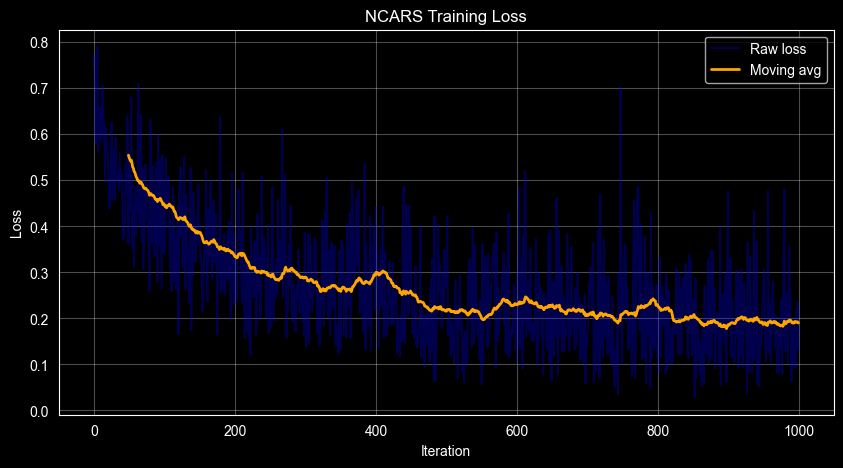

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, alpha=0.3, color='blue', label='Raw loss')
window = 50
moving_mean = np.convolve(losses, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(losses)), moving_mean, color='orange', linewidth=2, label=f'Moving avg')
plt.title(f'{dataset.upper()} Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Test Evaluation

In [12]:
dataset_obj.process(modes=["test"])
num_test_samples = dataset_obj.get_mode_length("test")
print(f"Test samples: {num_test_samples}")

test_set = BatchManager(
    dataset=dataset_obj,
    batch_size=32,
    mode="test"
)

evgnn.eval()
correct = 0
total = 0

print("Evaluating on test set...")
num_test_batches = (num_test_samples + 31) // 32

with torch.no_grad():
    for i in range(num_test_batches):
        examples = next(test_set)
        reference = examples.y.to(device)
        out = evgnn(examples)
        predictions = out.argmax(dim=-1)

        correct += (predictions == reference).sum().item()
        total += reference.size(0)

test_accuracy = correct / total
print(f"\n{'='*50}")
print(f"TEST ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*50}")

# Save results
import json
results = {
    'dataset': dataset,
    'architecture': 'fuse',
    'test_accuracy': float(test_accuracy),
    'num_test_samples': total
}

os.makedirs('results', exist_ok=True)
with open(f'results/test_results_{dataset}orig_aegnn.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: results/test_results_{dataset}_fuse.json")


test (cars):   0%|          | 0/4396 [00:00<?, ?it/s]

test (background):   0%|          | 0/4211 [00:00<?, ?it/s]

Test samples: 8607
Evaluating on test set...

TEST ACCURACY: 0.8719 (87.19%)
Results saved to: results/test_results_ncars_fuse.json
